## CNN-Based Wildfire Detection
Core libary set up + device set up

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Organizing Data Paths (Preparation)

In [3]:
from pathlib import Path
# setting up training and testing data paths
trainPath = Path("Train")
testPath = Path("Test")
# verifications
assert trainPath.exists(), "Training path DNE."
assert testPath.exists(), "Test path DNE."

print(f"Sub-directories of {trainPath}:")
for folder in trainPath.iterdir():
    print(folder)

print(f"Sub-directories of {testPath}:")
for folder in testPath.iterdir():
    print(folder)

Sub-directories of Train:
Train\Fire
Train\No_Fire
Sub-directories of Test:
Test\Fire
Test\No_Fire


#### Visualizing Some Data (Image)

Random training image path: Train\No_Fire\resized_frame3590.jpg
Training image class: No_Fire
Image height is: 254, and image width is: 254


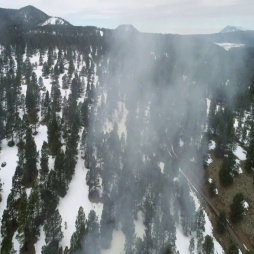

Random test image path: Test\Fire\resized_test_fire_frame1535.jpg
Test image class: Fire
Test image height is: 254, and image width is: 254


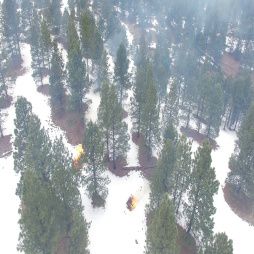

In [4]:
import random
from PIL import Image
# display properly renders images in jupyter notebook
from IPython.display import display

# visualize some images we have from our data
#random.seed(42)
# training images
trainImgPaths = list(trainPath.glob("*/*.jpg"))
randomTrainImgsPaths = random.choice(trainImgPaths)
trainImgClass = randomTrainImgsPaths.parent.stem
trainImg = Image.open(randomTrainImgsPaths)

print(f"Random training image path: {randomTrainImgsPaths}")
print(f"Training image class: {trainImgClass}")
print(f"Image height is: {trainImg.height}, and image width is: {trainImg.width}")
display(trainImg)

# test images
testImgPaths = list(testPath.glob("*/*.jpg"))
randomTestImgPaths = random.choice(testImgPaths)
testImgClass = randomTestImgPaths.parent.stem
testImg = Image.open(randomTestImgPaths)
print(f"Random test image path: {randomTestImgPaths}")
print(f"Test image class: {testImgClass}")
print(f"Test image height is: {testImg.height}, and image width is: {testImg.width}")
display(testImg)

#### Data Transformation using *torchvision.transforms*

In [5]:
# data transformation
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
dataTransformation = transforms.Compose([
    # downsizing images
    transforms.Resize(size = (64, 64)),
    # augmentation
    transforms.RandomHorizontalFlip(p = 0.3),
    # convert into tensor
    transforms.ToTensor() #0-255 into 0-1
])

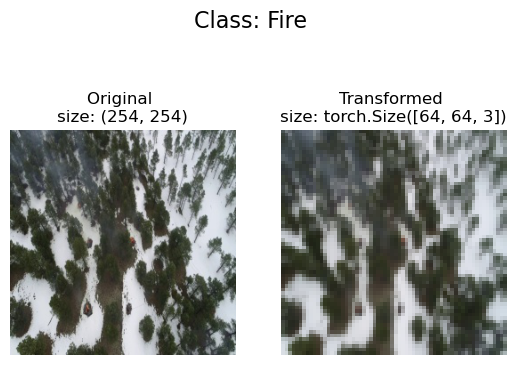

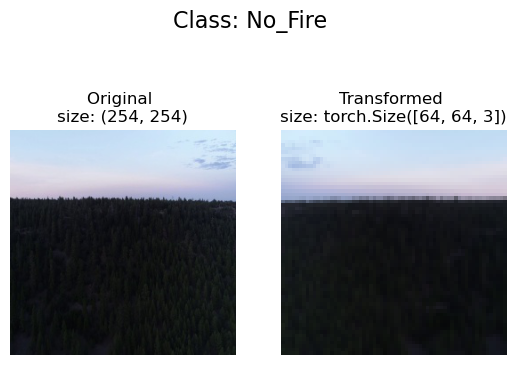

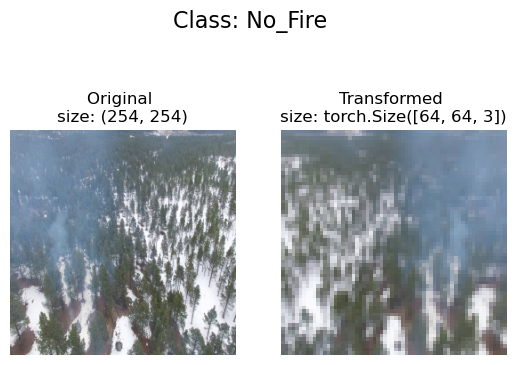

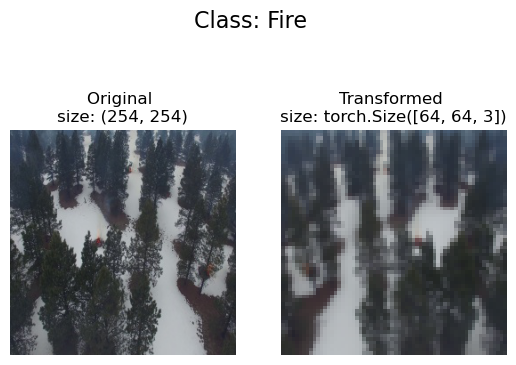

In [7]:
def plotTransformedImages(imgPath, transform, n = 3, seed = 42):
    #random.seed(seed)
    randomImgPaths = random.sample(imgPath, k = n)
    for imgPath in randomImgPaths:
        with Image.open(imgPath) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nsize: {f.size}")
            ax[0].axis("off")

            # transform the image
            # permute rearranges into: [height, width, color channel]
            # matplotlib perfers HWC image format
            transformedImg = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformedImg)
            # now that it is tensor, we use shape instead of size
            ax[1].set_title(f"Transformed \nsize: {transformedImg.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {imgPath.parent.stem}", fontsize = 16)

plotTransformedImages(trainImgPaths, transform=dataTransformation, n = 2)
plotTransformedImages(testImgPaths, transform=dataTransformation, n = 2)

#### Creating *Dataset* using *ImageFolder*

In [8]:
# PyTorch ImageFolder for dataset creation 
# Each class has their own directories, we can use ImageFolder
trainData = datasets.ImageFolder(root = trainPath, 
                                 transform = dataTransformation,
                                 # we do not transform image labels
                                 target_transform = None)
testData = datasets.ImageFolder(root = testPath, 
                                transform = dataTransformation)

print(f"Train data: \n{trainData} \n Test data: {testData}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 39375
    Root location: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           ) 
 Test data: Dataset ImageFolder
    Number of datapoints: 8617
    Root location: Test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           )


In [9]:
# some dataset info
classNames = trainData.classes
classDictionary = trainData.class_to_idx
print(f"Classes are: {classNames}")
print(f"Indexed classes: {classDictionary}")
print(f"The total number training images are: {len(trainData)}, whereas test images are: {len(testData)}")

print(f"")

Classes are: ['Fire', 'No_Fire']
Indexed classes: {'Fire': 0, 'No_Fire': 1}
The total number training images are: 39375, whereas test images are: 8617



In [10]:
# NOTICE: 
img, label = trainData[0][0], testData[0][0]
# default, un-permuted tensor shape
# [color channel, height, width]
print(f"Shape: {img.shape}, and {label.shape}")

Shape: torch.Size([3, 64, 64]), and torch.Size([3, 64, 64])


#### Turning *Dataset* into *DataLoader*

In [11]:
# Our images are effectively PyTorch Datasets
# Using torch.utils.data.DataLoader, we turn them into DataLoader
# DataLoader is iterable, the model can go through them and learn
import os
from torch.utils.data import DataLoader

count = os.cpu_count()
print(f"CPU has {count} threads available.")

trainDataLoader = DataLoader(dataset=trainData,
                            batch_size=32, #32 images per batch
                            num_workers=count,
                            shuffle=True)

testDataLoader = DataLoader(dataset=testData,
                            batch_size=16,
                            num_workers=count,
                            shuffle=False) # test data is usually not shuffled

# verify 
trainDataLoader, testDataLoader

CPU has 12 threads available.


(<torch.utils.data.dataloader.DataLoader at 0x24d7e3f0a90>,
 <torch.utils.data.dataloader.DataLoader at 0x24d00026a90>)

In [12]:
# Verify the shapes 
img, label = next(iter(trainDataLoader))

print(f"Image shape: {img.shape} formatted as [batch_size, color_channels, height, width]")
print(f"Label shape is {label.shape}") # we have a total of "this much" labels for all images in each batch

Image shape: torch.Size([32, 3, 64, 64]) formatted as [batch_size, color_channels, height, width]
Label shape is torch.Size([32])
